In [13]:
import numpy as np
import pandas as pd
import os, pickle, csv, glob, copy
import nibabel as nb
from nilearn import plotting, datasets
from nilearn.image import new_img_like

##### Time window and data directory setting 

In [6]:
#change both the time window and the max t stat accordingly
time_window = '15s'
wdir = 'C:/Users/andre/Desktop/Salerno/projects/gpt/scripts/GPT2_word_saliency_fMRI/outputs'

##### Loading atlas

In [7]:
atlas = nb.load(os.path.join('C:/Users/andre/Desktop/Salerno/projects/gpt/scripts/GPT2_word_saliency_fMRI/data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'))
atlas4plot = datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7, resolution_mm=2)

##### Get .csv files where are the results (from the analyses in Matlab) 

In [10]:
surp_results = pd.read_csv(os.path.join(wdir,time_window,'surprisal_analysis','Surp_FW_vs_BW_interaction.csv'),delimiter=',')
saliency_results = pd.read_csv(os.path.join(wdir,time_window,'saliency_analysis','Saliency_FW_vs_BW.csv'),delimiter=',')             

##### Create nifti files with the results of the contrast FW>BW (both surprisal and saliency)

In [14]:
surp_t = []
importance_t = []

all_results = [surp_results,saliency_results]
atlas_data = atlas.get_fdata()

for j,res in enumerate(all_results):
    
    print(j)
    #get the atlas
    atlas_mat = copy.deepcopy(atlas_data)
    new_data = np.zeros_like(atlas_mat)
    
    for i in range(len(res['ID'])):

        atlas_val = res.iloc[i]['ID']

        if res.iloc[i]['Bonf'] == 1:
            if res.iloc[i]['t stat'] > 0:
                new_data[atlas_mat == atlas_val] = res.iloc[i]['t stat']
                
                if j==0:
                    surp_t.append(res.iloc[i]['t stat'])
                else:
                    importance_t.append(res.iloc[i]['t stat'])
                    
            else:
                new_data[atlas_mat == atlas_val] = 0
        else:
            new_data[atlas_mat == atlas_val] = 0

    bonf_nii_pos = new_img_like(atlas, new_data)
    
    
    if j==0:
        bonf_nii_pos.to_filename(os.path.join(wdir,time_window,'surprisal_analysis/FWsurp_higher_BWsurp_atlas1000_bonf05.nii.gz'))
    else:
        bonf_nii_pos.to_filename(os.path.join(wdir,time_window,'saliency_analysis/FWsaliency_higher_BWsaliency_atlas1000_bonf05.nii.gz'))

0
1


##### Create nifti for each significant ROI files with the results of the contrast FW>BW (both surprisal and saliency)

In [15]:
atlas_data = atlas.get_fdata()
from nilearn.image import new_img_like

#list of the csv files with the results of both analyses
all_results = [surp_results,importance_results]

list_of_atlases = []

for j,res in enumerate(all_results):
    

    
    for i in range(len(res['ID'])):
        #get the atlas
        atlas_mat = copy.deepcopy(atlas_data)
        atlas_val = res.iloc[i]['ID']

        if res.iloc[i]['Bonf'] == 1 and res.iloc[i]['t stat']>0:

            atlas_mat[atlas_mat != atlas_val]=0
            atlas_mat[atlas_mat == atlas_val] = res.iloc[i]['t stat']
            
            tmp_nii = new_img_like(atlas, atlas_mat)
        
            if j==0:
                tmp_nii.to_filename(os.path.join(wdir,time_window,'surprisal_analysis/activations/'+str(i)+'_bonf05.nii.gz'))
            else:
                tmp_nii.to_filename(os.path.join(wdir,time_window,'saliency_analysis/activations/'+str(i)+'_bonf05.nii.gz'))

##### Visualization on the volume of the ROIs where FW is significantly higher than BW

C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
C:\Users\andre\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays.py:103: UserWarning: No contour levels were found within the data range.
  **kwargs)


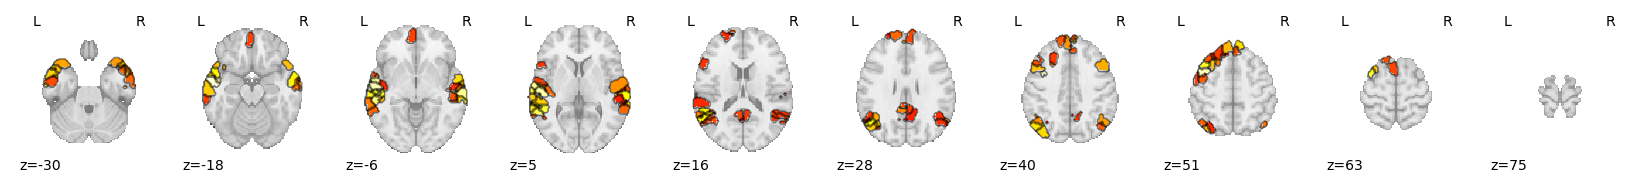

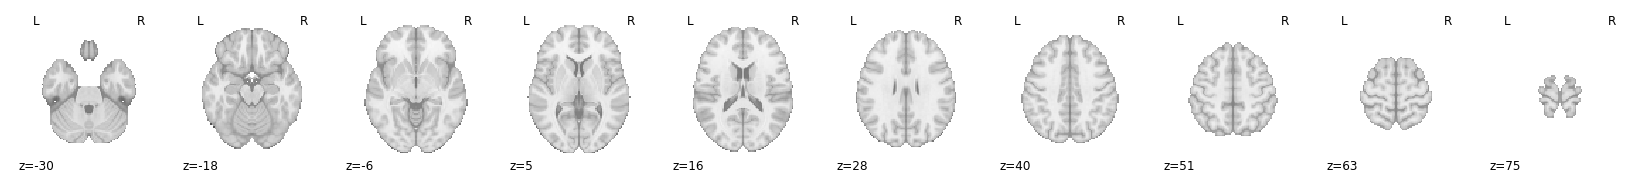

In [16]:
surp_max_t = 10 #max t across all time windows
importance_max_t = 6.5 #max t across all time windows

from nilearn.plotting import plot_glass_brain, plot_roi
import glob
surp_files = glob.glob(os.path.join(wdir,time_window,'surprisal_analysis/activations/*.nii.gz'))
importance_files = glob.glob(os.path.join(wdir,time_window,'saliency_analysis/activations/*.nii.gz'))


display = plot_roi(None,display_mode='z', 
                            cut_coords = 10, 
                            annotate=True,
                            black_bg=False,
                            colorbar=True,
                            threshold=1, resampling_interpolation = 'nearest')


#SUPRRISAL
for tmp_nii in surp_files:
    display.add_overlay(tmp_nii,
                        vmax= surp_max_t,
                        vmin=0, 
                        cmap = 'hot')
    
    display.annotate(size=14)

    display.add_contours(tmp_nii, filled=False, levels=[.1], alpha=.5, colors=['black'])
    
display.savefig(os.path.join(wdir,time_window,'Surp_FW_vs_BW.svg'),dpi=600)



#SALIENCY
display = plot_roi(None,display_mode='z', 
                            cut_coords = 10, 
                            annotate=True,
                            black_bg=False,
                            colorbar=True,
                            threshold=1, resampling_interpolation = 'nearest')
# Here, we project statistical maps
for tmp_nii in importance_files:
    display.add_overlay(tmp_nii,
                        vmax= importance_max_t,
                        vmin=0, 
                        cmap = 'hot')
    
    display.annotate(size=14)

    display.add_contours(tmp_nii, filled=False, levels=[.1], alpha=.5, colors=['black'])
    
display.savefig(os.path.join(wdir,time_window,'Saliency_FW_vs_BW.svg'),dpi=600)